# load img2label dataset

In [1]:
%install-location $cwd/swift-install
%install-swiftpm-flags -c release
// %install '.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.8"))' Batcher ModelSupport Datasets
%install '.package(path: "/notebooks/language2motion.gt/code")' Batcher ModelSupport Datasets

Installing packages:
	.package(path: "/notebooks/language2motion.gt/code")
		Batcher
		ModelSupport
		Datasets
With SwiftPM flags: ['-c', 'release']
Working in: /tmp/tmpqj73wk4s/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
Initializing Swift...
Installation complete!


In [2]:
import Foundation
import PythonKit
import TensorFlow

import Batcher
import ModelSupport
import Datasets

In [3]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let random  = Python.import("random")
let sklearn  = Python.import("sklearn")
let model_selection  = Python.import("sklearn.model_selection")
let subprocess = Python.import("subprocess")
let glob = Python.import("glob")
let pil = Python.import("PIL")

In [4]:
// TODO:
// - download dataset if not present
// - unpack dataset
// - enumerate folders, get labels
// + enumerate images
// - sort image paths
// + load image
// + create [TensorPair<Float, Int32>] list
// + create dataset object
// - calculate normalization
// + split into training/test

## load image

In [5]:
let im65URL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1/Doing something/00065.png")

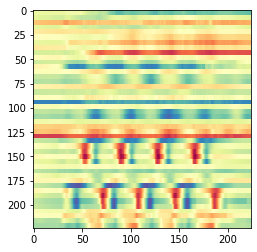

None


In [6]:
let img = pil.Image.open(im65URL.path)
plt.imshow(img)
plt.show()

## enumerate folders, get labels
## enumerate images

In [7]:
// TODO: sort images

In [8]:
/// load the image and extract the label
/// from Swift4TF_TransferLearning.ipynb
func getTensorLabel(_ imageURL: URL, labels: [String]) -> (Tensor<Float>, Int32){
  
    let label: Int32
  
    let labelStr = imageURL.deletingLastPathComponent().lastPathComponent
    label = Int32(labels.index(of: labelStr)!)
  
    let img = pil.Image.open(imageURL.path)
    let arr = np.array(img)[0..<224, 0..<224, 0..<3] // kill transparency
    let image = Tensor<UInt8>(numpy: arr)!

    var tensor = Tensor<Float>(image)
    tensor = Raw.expandDims(tensor, dim: Tensor<Int32>(0))
    tensor = Raw.resizeArea(images:tensor, size:[224, 224])
    return (tensor.squeezingShape(at: 0), label)
}

// let (tensor, label) = getTensorLabel(URL(fileURLWithPath: im65URL.path), labels: labels)
// tensor.shape

In [9]:
func loadImages(imageList: [String], labels: [String], normalizing: Bool = true) -> [TensorPair<Float, Int32>] {
    let tensorLabels = imageList.map {
        getTensorLabel(URL(fileURLWithPath: $0), labels: labels)
    }
    
    let imageCount = tensorLabels.count
    let labelTensor = Tensor<Int64>(shape: [imageCount], scalars: tensorLabels.map {Int64($0.1)})

    var imageTensor = Tensor<Float>(stacking: tensorLabels.map {$0.0}, alongAxis: 0)

    // The value of mean and std were calculated with the following Swift code:
    // ```
    // import TensorFlow
    // import Datasets
    // import Foundation
    // let urlString = "https://storage.googleapis.com/s4tf-hosted-binaries/datasets/CIFAR10/cifar-10-binary.tar.gz"
    // let cifar = CIFAR10(batchSize: 50000,
    //                     remoteBinaryArchiveLocation: URL(string: urlString)!,
    //                     normalizing: false)
    // for batch in cifar.training.sequenced() {
    //     let images = Tensor<Double>(batch.first) / 255.0
    //     let mom = images.moments(squeezingAxes: [0,1,2])
    //     print("mean: \(mom.mean) std: \(sqrt(mom.variance))")
    // }
    // ```
    if normalizing {
        let mean = Tensor<Float>(
                [0.4913996898,
                 0.4821584196,
                 0.4465309242])
        let std = Tensor<Float>(
                [0.2470322324,
                 0.2434851280,
                 0.2615878417])
        imageTensor = ((imageTensor / 255.0) - mean) / std
    }
    
    return (0..<imageCount).map { TensorPair(first: imageTensor[$0], second: Tensor<Int32>(labelTensor[$0])) }
        
}

In [10]:
public struct Img2Label: ImageClassificationDataset {
    public typealias SourceDataSet = [TensorPair<Float, Int32>]
    public let training: Batcher<SourceDataSet>
    public let test: Batcher<SourceDataSet>

    public init(batchSize: Int) {
        let dsURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1", isDirectory: true)
        self.init(batchSize: batchSize, dsURL: dsURL)
    }

    public init(batchSize: Int, dsURL: URL) {
        let imageList = glob.glob(dsURL.path + "/**/*.png")
        // TODO: sort images
        let (trainPythonList, testPythonList) = model_selection.train_test_split(imageList, test_size: 0.2).tuple2
        let (trainList, testList): ([String], [String]) = (Array(trainPythonList)!, Array(testPythonList)!)
        
        let labels = [
            "Doing something",
            "Performing motions with hands",
            "Walking and turning",
            "Walking forward few steps",
            "Walking or running"
        ]
        let trainTensorPairs = loadImages(imageList: trainList, labels: labels, normalizing: true)
        print("trainTensorPairs.count = \(trainTensorPairs.count)")
        let testTensorPairs = loadImages(imageList: testList, labels: labels, normalizing: true)
        print("testTensorPairs.count = \(testTensorPairs.count)")
        self.training = Batcher(
            on: trainTensorPairs,
            batchSize: batchSize,
            numWorkers: 1, //No need to use parallelism since everything is loaded in memory
            shuffle: true)
        self.test = Batcher(
            on: testTensorPairs,
            batchSize: batchSize,
            numWorkers: 1,
            shuffle: true)
    }
}

In [11]:
let batchSize = 25

let dsURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1", isDirectory: true)

let dataset = Img2Label(batchSize: batchSize, dsURL: dsURL)
print("dataset.training.count: \(dataset.training.count)")
print("dataset.test.count: \(dataset.test.count)")

trainTensorPairs.count = 2409
testTensorPairs.count = 603
dataset.training.count: 97
dataset.test.count: 25
